In [ ]:
from __future__ import absolute_import, division, print_function

import math

import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.layers import Dense, Input, Dropout
from keras.models import Model
from keras.callbacks import EarlyStopping

print(tf.__version__)

In [ ]:
# Define default plot styles  

from matplotlib import rc
import matplotlib.font_manager

rc('font', family='serif')
rc('text', usetex=True)
rc('font', size=22)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

plot_style_0 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'linestyle': '--',
    'density': False
}

plot_style_1 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'density': False
}

plot_style_2 = {'alpha': 0.5, 'density': False}

In [175]:
# use pyroot for I/O
import ROOT
from ROOT import TCanvas, TPad, TFile, TPaveText
from ROOT import gBenchmark, gStyle, gROOT
def getarray_selected(filename):
    f = TFile(filename)
    tree = gROOT.FindObject('selectedEvents')
    array = tree.AsMatrix(columns=[ "dptt_rec","cutBranch","pN_rec","daT_rec","muMomRec","muCosThetaRec","piMomRec","piCosThetaRec","pMomRec","pCosThetaRec","weight",
                                    "topology","target","dptt_truth","pN_truth","daT_truth",
                                    "muMomTrue","muCosThetaTrue","piMomTrue","piCosThetaTrue","pMomTrue","pCosThetaTrue","Enutrue"])
    #array11=array[array[:,8]==1]
    array11=array
    for i in range(len(array11)):
        if array11[i,0]<-700:
            array11[i,0]=-701
        elif array11[i,0]>700:
            array11[i,0]=701
        if array11[i,1]>0:
            array11[i,0]=array11[i,0]+1400#*array11[i,1]
        if array11[i,13]<-700:
            array11[i,13]=-701
        elif array11[i,13]>700:
            array11[i,13]=701
        if array11[i,11]<2 or array11[i,11]>3:
            array11[i,13]=-701
    array11=array11[array11[:,10]>0]
    array11=array11[array11[:,0]<2100]
    #array11=array11[array11[:,9]==1]
    #array11=array11[:,0:7]
    #array11[:,0]=array11[:,0]/10**3 # unit conversion to make all numbers to be O(1)
    #array11[:,1]=array11[:,1]/5
    #array11[:,2]=array11[:,2]/180
    #array11[:,3]=array11[:,3]/5
    #array11[:,4]=array11[:,4]/10**3
    #array11[:,6]=array11[:,6]/10**3
    #array11[:,8]=array11[:,8]/10**3
    #nGenEv = 40000000 # total number of events generated in the file, to calculate proper xsec normalization
    return array11#,array[0,7]/nGenEv
selected_neut6T = getarray_selected('/hepstore/kmtsui/T2K/work/xsLLhFitter_super/inputs/neut_prod6T_allTKI_geomfixed.root')
selected_genie = getarray_selected('/hepstore/kmtsui/T2K/work/xsLLhFitter_super/inputs/genie_allTKI_geomfixed.root')

In [ ]:
selected_neut6T = getarray_selected('/hepstore/kmtsui/T2K/work/xsLLhFitter_super/inputs/neut_prod6T_allTKI_geomfixed.root')
selected_genie = getarray_selected('/hepstore/kmtsui/T2K/work/xsLLhFitter_super/inputs/genie_allTKI_geomfixed.root')

In [176]:
neut6T_reco=selected_neut6T[:,0]
neut6T_true=selected_neut6T[:,13]
weight_neut6T=selected_neut6T[:,10]
genie_reco=selected_genie[:,0]
genie_true=selected_genie[:,13]
weight_genie=selected_genie[:,10]

In [172]:
# set up the DNN model for training
ndim=1
inputs = Input((ndim, )) # 7d vector as input
hidden_layer_1 = Dense(100, activation='relu')(inputs)
dropout_layer_1 = Dropout(0.)(hidden_layer_1)
hidden_layer_2 = Dense(100, activation='relu')(dropout_layer_1)
dropout_layer_2 = Dropout(0.)(hidden_layer_2)
hidden_layer_3 = Dense(100, activation='relu')(dropout_layer_2)
dropout_layer_3 = Dropout(0.)(hidden_layer_3)
outputs = Dense(1, activation='sigmoid')(dropout_layer_3)

model = Model(inputs=inputs, outputs=outputs)

earlystopping = EarlyStopping(patience=20, 
                              verbose=1,
                              restore_best_weights=False)


In [184]:
from tensorflow_addons.optimizers import AdamW
from tensorflow.keras.layers.experimental import preprocessing


weights_pull = np.ones(len(weight_neut6T))*weight_neut6T
weights_push = np.ones(len(weight_neut6T))*weight_neut6T
#weights_pull = weight_neut6T
#weights_push = weight_neut6T

xvals_1 = np.concatenate((neut6T_reco, genie_reco))
yvals_1 = np.concatenate(( np.zeros(len(neut6T_reco)), np.ones(len(genie_reco)) ))

#xvals_2 = np.concatenate((neut6T_true[abs(neut6T_true)<700], neut6T_true[abs(neut6T_true)<700]))
#yvals_2 = np.concatenate(( np.zeros(len(neut6T_true[abs(neut6T_true)<700])), np.ones(len(neut6T_true[abs(neut6T_true)<700])) ))
xvals_2 = np.concatenate((neut6T_true, neut6T_true))
yvals_2 = np.concatenate(( np.zeros(len(neut6T_true)), np.ones(len(neut6T_true)) ))

layer_reco = preprocessing.Normalization()
layer_reco.adapt(xvals_1)
xvals_1 = layer_reco(xvals_1).numpy()

layer_true = preprocessing.Normalization()
layer_true.adapt(xvals_2)
xvals_2 = layer_true(xvals_2).numpy()

batch_size_defined = 100#int(len(selected_neut6T)/100)
# from NN (DCTR)
def reweight_reco(events):
    f = model.predict(layer_reco(events).numpy(), batch_size=batch_size_defined)
    weights = f / (1. - f)
    weights[weights>10]=10
    return np.squeeze(np.nan_to_num(weights))

def reweight_true(events):
    f = model.predict(layer_true(events).numpy(), batch_size=batch_size_defined)
    weights = f / (1. - f)
    weights[weights>10]=10
    return np.squeeze(np.nan_to_num(weights))

iterations = 10
weights = np.empty(shape=(iterations, 2, len(neut6T_reco)))

for i in range(iterations):
    print("\nITERATION: {}\n".format(i + 1))

    # STEP 1: classify Sim. (which is reweighted by weights_push) to Data
    # weights reweighted Sim. --> Data
    print("STEP 1\n")

    weights_1 = np.concatenate((weights_push, weight_genie))
    # actual weights for Sim., ones for Data (not MC weights)

    X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(
        xvals_1, yvals_1, weights_1)

    model.compile(loss='binary_crossentropy',
                  optimizer='Adam',
                  metrics=['accuracy'])
    model.fit(X_train_1,
              Y_train_1,
              sample_weight=w_train_1,
              epochs=200,
              batch_size=batch_size_defined,
              validation_data=(X_test_1, Y_test_1, w_test_1),
              callbacks=[earlystopping],
              verbose=1)

    weights_pull = weights_push * reweight_reco(neut6T_reco)

    weights[i, :1, :] = weights_pull

    # STEP 2: classify Gen. to reweighted Gen. (which is reweighted by weights_pull)
    # weights Gen. --> reweighted Gen.
    print("\nSTEP 2\n")

    #weights_2 = np.concatenate((weights_push[abs(neut6T_true)<700], weights_pull[abs(neut6T_true)<700]))
    #weights_2 = np.concatenate((np.ones(len(weights_push[abs(neut6T_true)<700])), weights_pull[abs(neut6T_true)<700]))
    #weights_2 = np.concatenate((np.ones(len(weights_push)), weights_pull))
    weights_2 = np.concatenate((weight_neut6T, weights_pull))
    # ones for Gen. (not MC weights), actual weights for (reweighted) Gen.

    X_train_2, X_test_2, Y_train_2, Y_test_2, w_train_2, w_test_2 = train_test_split(
        xvals_2, yvals_2, weights_2)

    model.compile(loss='binary_crossentropy',
                  optimizer='Adam',
                  metrics=['accuracy'])
    model.fit(X_train_2,
              Y_train_2,
              sample_weight=w_train_2,
              epochs=200,
              batch_size=batch_size_defined,
              validation_data=(X_test_2, Y_test_2, w_test_2),
              callbacks=[earlystopping],
              verbose=1)

    weights_push=reweight_true(neut6T_true)*weight_neut6T
    #weights_push[abs(neut6T_true)<700] = reweight_true(neut6T_true[abs(neut6T_true)<700])#*weights_push[abs(neut6T_true)<700]
    #weights_push[abs(neut6T_true)>=700] = weights_pull[abs(neut6T_true)>=700]
    
    ###    
    
    weights[i, 1:2, :] = weights_push

 loss: 0.0595 - accuracy: 0.4651 - val_loss: 0.0594 - val_accuracy: 0.4557
Epoch 48/200
270/270 [==============================] - 0s 2ms/step - loss: 0.0594 - accuracy: 0.4662 - val_loss: 0.0594 - val_accuracy: 0.4576
Epoch 00048: early stopping

STEP 2

Epoch 1/200
314/314 [==============================] - 2s 5ms/step - loss: 0.0510 - accuracy: 0.4955 - val_loss: 0.0514 - val_accuracy: 0.5011
Epoch 2/200
314/314 [==============================] - 1s 2ms/step - loss: 0.0512 - accuracy: 0.4963 - val_loss: 0.0514 - val_accuracy: 0.5010
Epoch 3/200
314/314 [==============================] - 0s 2ms/step - loss: 0.0513 - accuracy: 0.4981 - val_loss: 0.0514 - val_accuracy: 0.5005
Epoch 4/200
314/314 [==============================] - 0s 2ms/step - loss: 0.0512 - accuracy: 0.4991 - val_loss: 0.0514 - val_accuracy: 0.5004
Epoch 5/200
314/314 [==============================] - 0s 2ms/step - loss: 0.0512 - accuracy: 0.4957 - val_loss: 0.0514 - val_accuracy: 0.5006
Epoch 6/200
314/314 [========

ITERATION 1:
ITERATION 2:
ITERATION 3:
ITERATION 4:
ITERATION 5:
ITERATION 6:
ITERATION 7:
ITERATION 8:
ITERATION 9:
ITERATION 10:
/user/kmtsui/.local/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<Figure size 864x360 with 0 Axes>

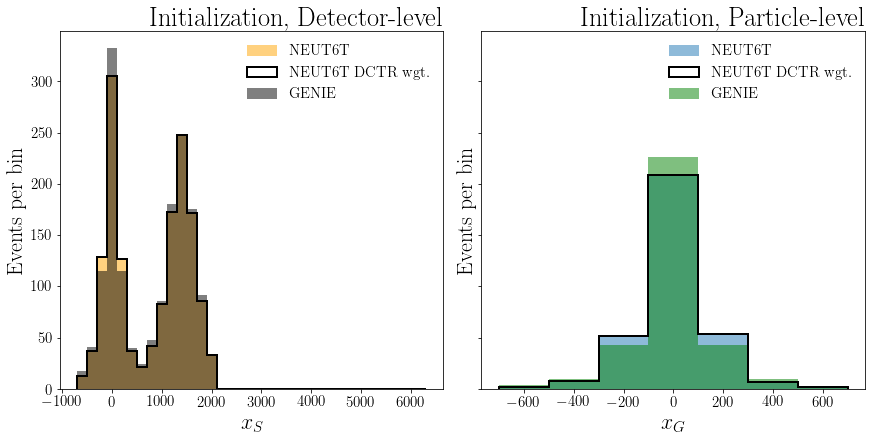

<Figure size 864x360 with 0 Axes>

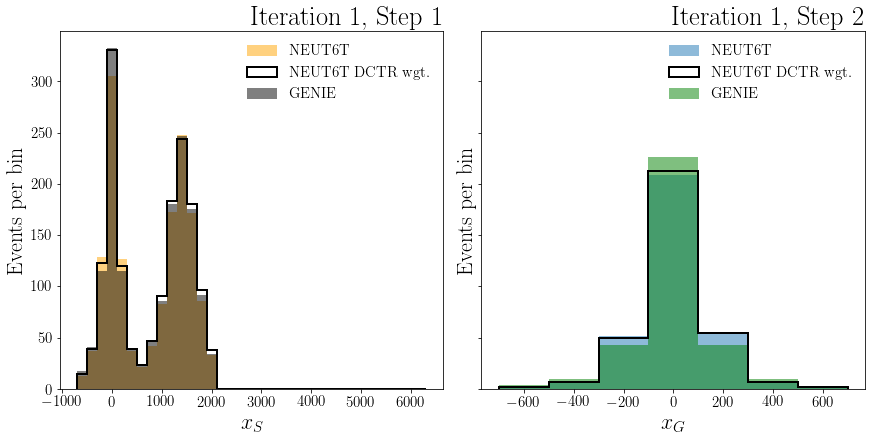

<Figure size 864x360 with 0 Axes>

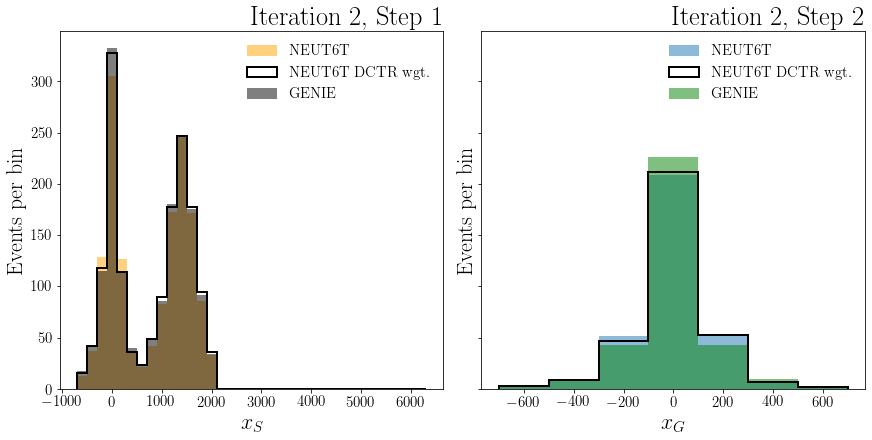

<Figure size 864x360 with 0 Axes>

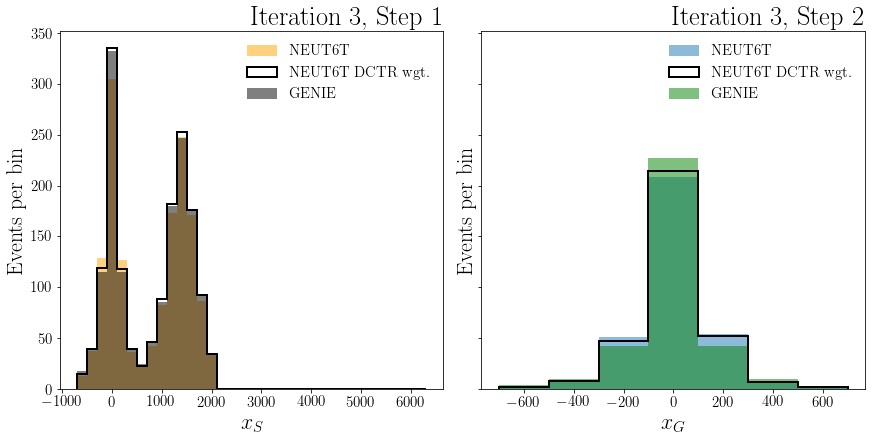

<Figure size 864x360 with 0 Axes>

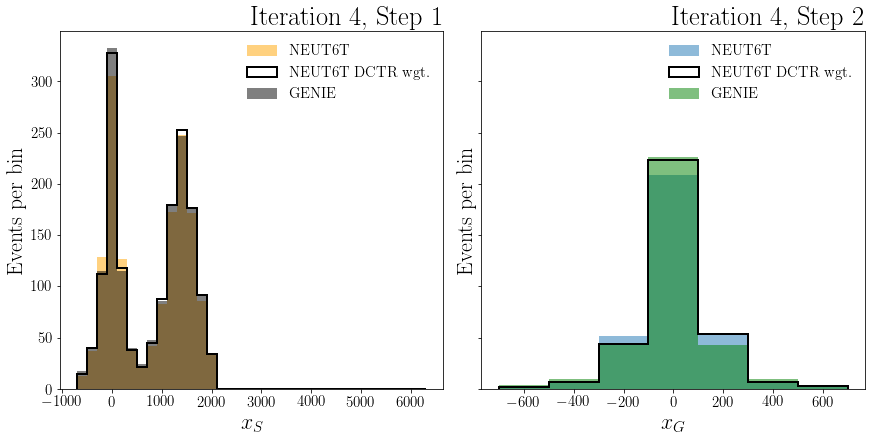

<Figure size 864x360 with 0 Axes>

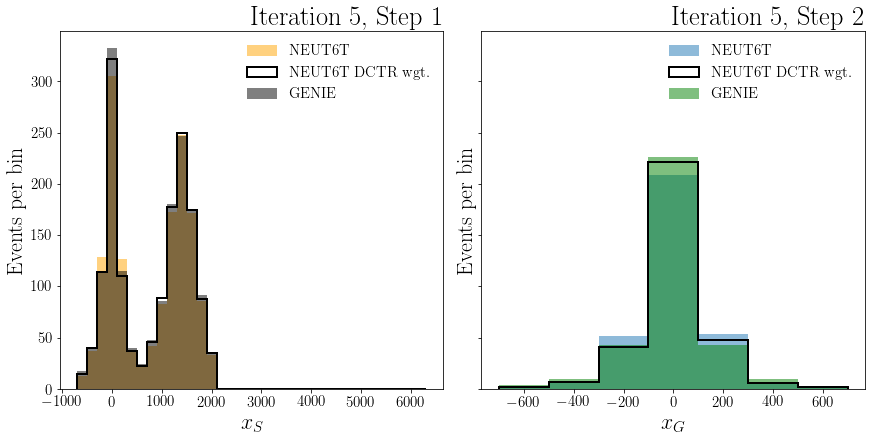

<Figure size 864x360 with 0 Axes>

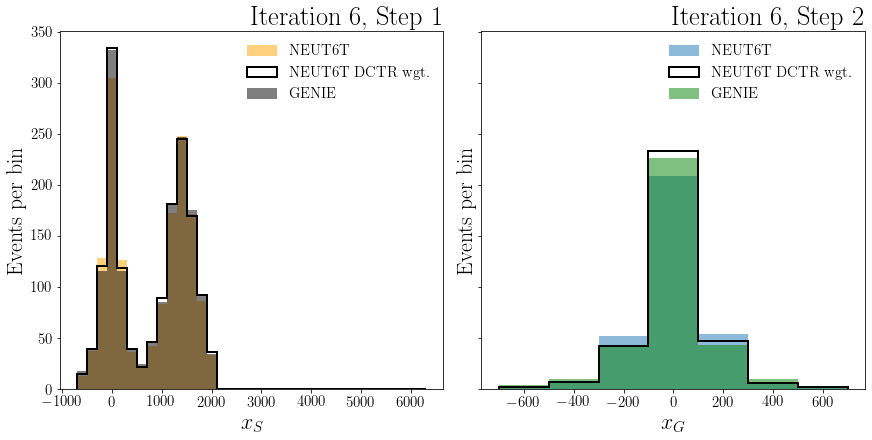

<Figure size 864x360 with 0 Axes>

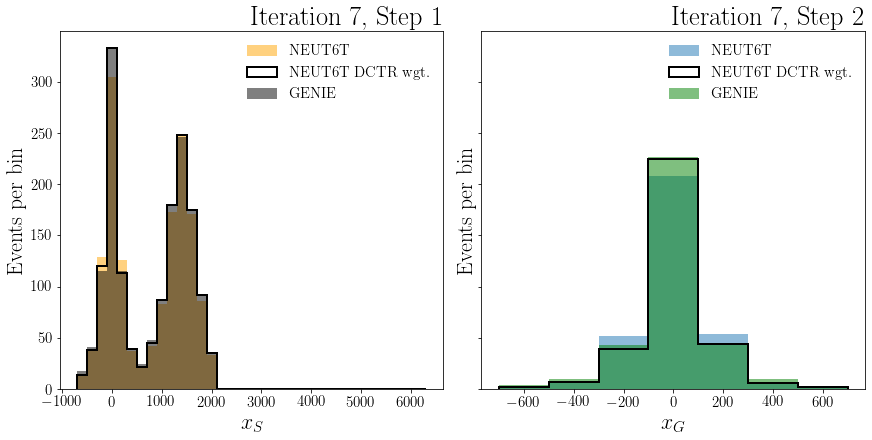

<Figure size 864x360 with 0 Axes>

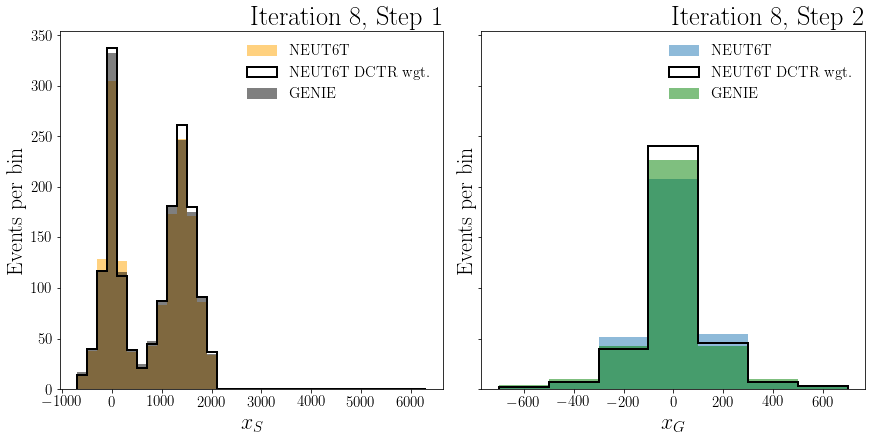

<Figure size 864x360 with 0 Axes>

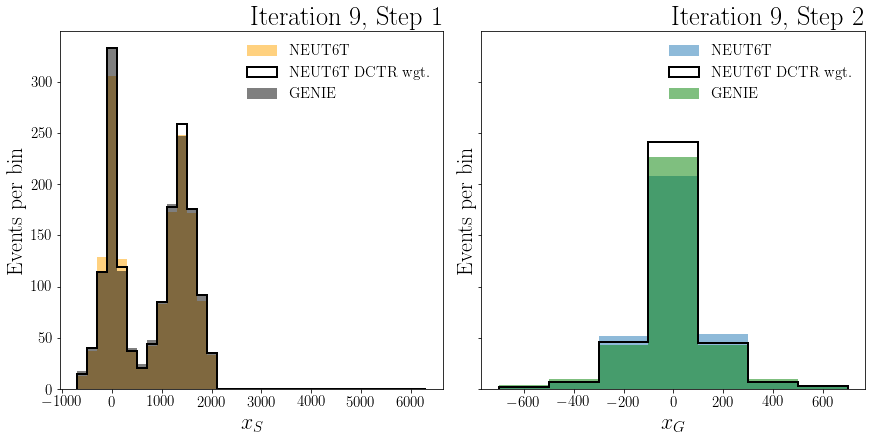

<Figure size 864x360 with 0 Axes>

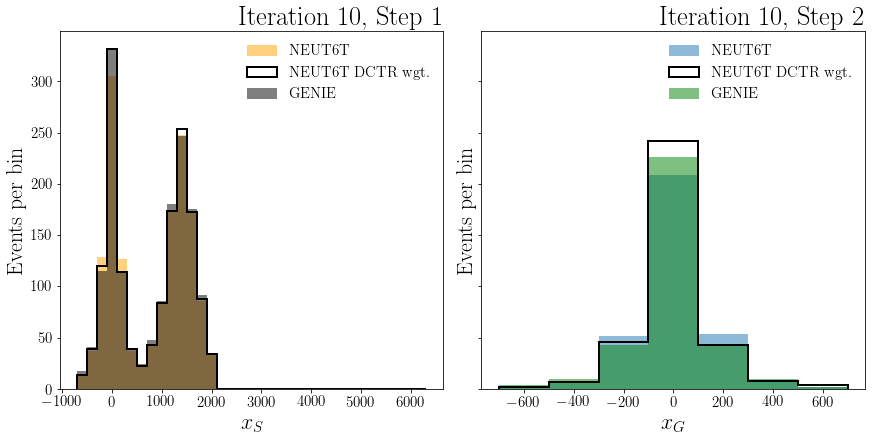

In [185]:

bins_reco = np.linspace(-700, 6300, 36)
bins_true = np.linspace(-700, 700, 8)

plt.figure(figsize=(12, 5))

fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 6),
                       constrained_layout=True,
                       sharey=True)

#Detector-level
ax[0].set_title("Initialization, Detector-level",style='italic',loc='right')
hist0 = ax[0].hist(neut6T_reco,
                 bins=bins_reco,
                 color="orange",
                 label=r'NEUT6T',
                 weights=weight_neut6T,
                 **plot_style_2)

_,_,_= ax[0].hist(
    neut6T_reco,
    bins=bins_reco,
    label='NEUT6T DCTR wgt.',
    weights=weight_neut6T,
    **plot_style_1)
_,_,_= ax[0].hist(genie_reco,
                 bins=bins_reco,
                 label='GENIE',
                 weights=weight_genie,
                 **plot_style_2,
                color="black")
ax[0].legend(frameon=False)
ax[0].set_xlabel(r"$x_S$")
ax[0].set_ylabel("Events per bin")

#Particle-level
ax[1].set_title("Initialization, Particle-level",style='italic',loc='right')
_,_,_=ax[1].hist(neut6T_true,
                 bins=bins_true, weights=weight_neut6T,
                 label='NEUT6T',
                 **plot_style_2)

_,_,_= ax[1].hist(
    neut6T_true,
    bins=bins_true, weights=weight_neut6T,
    label='NEUT6T DCTR wgt.',
    **plot_style_1)
_,_,_= ax[1].hist(genie_true,
                 bins=bins_true, weights=weight_genie,
                 label='GENIE',
                 **plot_style_2,
                color="green")
ax[1].legend(frameon=False)
ax[1].set_xlabel(r"$x_G$")
ax[1].set_ylabel("Events per bin")

plt.savefig("plot_0.pdf")

#Iterations
for i in range(iterations):
    print("ITERATION {}:".format(i + 1))
    plt.figure(figsize=(12, 5))
    
    fig, ax = plt.subplots(1,2,
                       figsize=(12, 6),
                       constrained_layout=True,
                       sharey=True
                       )
    
    #Detector-level
    ax[0].set_title("Iteration " +str(i+1)+ ", Step 1",style='italic',loc='right')
    _,_,_ = ax[0].hist(neut6T_reco,
                     bins=bins_reco, weights=weight_neut6T,
                     label='NEUT6T',
                     color="orange",
                     **plot_style_2)

    _,_,_ = ax[0].hist(
        neut6T_reco,
        bins=bins_reco,
        label='NEUT6T DCTR wgt.',
        weights=weights[i, 0, :],
        **plot_style_1)
    _,_,_ = ax[0].hist(genie_reco,
                     bins=bins_reco, weights=weight_genie,
                     label='GENIE',
                     **plot_style_2,
                    color="black")
    ax[0].legend(frameon=False)
    ax[0].set_xlabel(r"$x_S$")
    ax[0].set_ylabel("Events per bin")
    
    #Particle-level
    ax[1].set_title("Iteration " +str(i+1)+ ", Step 2",style='italic',loc='right')
    _,_,_ = ax[1].hist(neut6T_true,
                     bins=bins_true, weights=weight_neut6T,
                     label='NEUT6T',
                     **plot_style_2)

    _,_,_ = ax[1].hist(
        neut6T_true,
        bins=bins_true,
        label='NEUT6T DCTR wgt.',
        weights=weights[i, 1, :],
        **plot_style_1)
    _,_,_ = ax[1].hist(genie_true,
                     bins=bins_true, weights=weight_genie,
                     label='GENIE',
                     **plot_style_2,
                    color="green")
    ax[1].legend(frameon=False)
    ax[1].set_xlabel(r"$x_G$")
    ax[1].set_ylabel("Events per bin")
    
    plt.savefig("plot_"+str(i+1)+".pdf")

In [ ]:
np.save('selected_neut6T',selected_neut6T)
np.save('selected_genie',selected_genie)

In [ ]:
from tensorflow_addons.optimizers import AdamW
from tensorflow.keras.layers.experimental import preprocessing

#just use a fraction of data for training
#nevents = 10**6
batch_size_defined = int(len(selected_neut6T)/100)

x_data_and_MCback = np.concatenate([selected_neut6T[:,0:ndim],selected_genie[:,0:ndim]])

layer = preprocessing.Normalization()
layer.adapt(x_data_and_MCback)
x_data_and_MCback = layer(x_data_and_MCback).numpy()

y_data_and_MCback = np.concatenate([np.zeros(len(selected_neut6T[:,0:ndim])),
                                    np.ones(len(selected_genie[:,0:ndim]))])
    
W_data_and_MCback = np.concatenate([ selected_neut6T[:,10], selected_genie[:,10] ])
W_data_and_MCback = W_data_and_MCback/min(W_data_and_MCback)
#W_data_and_MCback = np.concatenate([ np.ones(len(selected_neut6T[:,0:ndim])), np.ones(len(selected_genie[:,0:ndim])) ])

X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split( 
    x_data_and_MCback, y_data_and_MCback, W_data_and_MCback)


optimizer = AdamW(weight_decay=0.01,learning_rate=0.01)

model.compile(loss='binary_crossentropy',
              optimizer= 'Adam',
              #optimizer= optimizer,
              metrics=['accuracy'])


model.fit(X_train_1,
          Y_train_1,
          sample_weight=w_train_1,
          epochs=200,
          batch_size=batch_size_defined,
          validation_data=(X_test_1, Y_test_1, w_test_1),
          callbacks=[earlystopping],
          verbose=1)


In [ ]:
# from NN (DCTR)
def reweight(events):
    f = model.predict(layer(events).numpy(), batch_size=batch_size_defined)
    weights = f / (1. - f)
    weights[weights>10]=10
    return np.squeeze(np.nan_to_num(weights))

In [ ]:
# get the reweight value
w_model = reweight(selected_neut6T[:,0:ndim])

In [ ]:
w_model

In [ ]:
# make plots
sampleIdx = 1
for plotNum in range(1):
        for sample in range(1):

                bins_dptt = np.linspace(-1000, 9000, 36)
                bins_pN = np.linspace(0,1.5, 11)
                bins_daT = np.linspace(0,1, 11)

                xlabel = (r"$\delta p_{TT} (MeV)$",r"$p_{N} (GeV)$",r"$\delta\alpha_{T}$")

                bins_array = (bins_dptt,bins_pN,bins_daT)
                legend_loc = ('upper right','center right','center left','center left','center left','center left','center right')

                bins_w= np.linspace(0, 10, 101)

                fig, ax = plt.subplots(2,
                                2,
                                figsize=(12, 10),
                                constrained_layout=True,
                                #sharey='row'
                                )

                binwidth = bins_array[plotNum][1]-bins_array[plotNum][0]

                ax[0,0].set_xlabel(xlabel[plotNum])
                ax[0,0].set_ylabel(r'Events per bin')
                #h1=ax[0,0].hist(selected_neut6T[abs(selected_neut6T[:,sampleIdx]-0.2*sample)<0.1][:,plotNum], bins=bins_array[plotNum], **plot_style_2, 
                #                label='NEUT6T',weights=selected_neut6T[abs(selected_neut6T[:,sampleIdx]-0.2*sample)<0.1][:,10],color="blue")
                #h2=ax[0,0].hist(selected_genie[abs(selected_genie[:,sampleIdx]-0.2*sample)<0.1][:,plotNum], bins=bins_array[plotNum], **plot_style_2, 
                 #               label='GENIE',weights=selected_genie[abs(selected_genie[:,sampleIdx]-0.2*sample)<0.1][:,10],color="red")
                #h3=ax[0,0].hist(selected_neut6T[abs(selected_neut6T[:,sampleIdx]-0.2*sample)<0.1][:,plotNum], bins=bins_array[plotNum], **plot_style_1, label='NEUT6T (reweighted)',
                 #               weights=selected_neut6T[abs(selected_neut6T[:,sampleIdx]-0.2*sample)<0.1][:,10]*w_model[abs(selected_neut6T[:,sampleIdx]-0.2*sample)<0.1])
                h1=ax[0,0].hist(selected_neut6T[:,plotNum], bins=bins_array[plotNum], **plot_style_2, 
                                label='NEUT6T',weights=selected_neut6T[:,10],color="blue")
                h2=ax[0,0].hist(selected_genie[:,plotNum], bins=bins_array[plotNum], **plot_style_2, 
                                label='GENIE',weights=selected_genie[:,10],color="red")
                h3=ax[0,0].hist(selected_neut6T[:,plotNum], bins=bins_array[plotNum], **plot_style_1, label='NEUT6T (reweighted)',
                                weights=selected_neut6T[:,10]*w_model)
                legend = ax[0,0].legend(
                        title='Sample '+str(sample),
                        loc=legend_loc[plotNum],
                        frameon=False)

                ax[1,0].set_xlabel('reweight value')
                ax[1,0].hist(w_model, bins=bins_w, **plot_style_2, label='NEUT weight',color="blue")

                ax[1,1].set_xlabel('reweight value')
                ax[1,1].set_ylabel(xlabel[plotNum])
                #ax[1,1].hist2d(w_model[selected_neut6T[:,sampleIdx]==0.2*sample], selected_neut6T[selected_neut6T[:,sampleIdx]==0.2*sample][:,plotNum], bins=(bins_w,bins_array[plotNum]))
                ax[1,1].hist2d(w_model, selected_neut6T[:,plotNum], bins=(bins_w,bins_array[plotNum]))

                #ax[2,0].hist2d(array11_Eb0[:,0], array11_Eb0[:,1], bins=(bins_mumom,bins_mumom))

                #ax[2,1].hist2d(array11_Eb27[:,0], array11_Eb27[:,1], bins=(bins_mumom,bins_mumom))

                fig.show()